In [1]:
import numpy as np
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LensModel.Solver.epl_shear_solver import caustics_epl_shear
from shapely.geometry import Polygon
import pointpats
import matplotlib.pyplot as plt

In [26]:
from ler.utils import add_dictionaries_together, trim_dictionary
from ler.lens_galaxy_population.jit_functions import velocity_dispersion_z_dependent, axis_ratio_rayleigh, phi_q2_ellipticity_hemanta
from ler.utils import inverse_transform_sampler, cubic_spline_interpolator
from numba import njit


def sample_lens_parameters(size, zs, zl, z_list, vd_inv_cdf):
    """
        Function to sample galaxy lens parameters along with the source parameters.
    """
    zs = np.array([zs] * size)
    zl = np.array([zl] * size)

    # Sample velocity dispersions
    vd_inv_cdf_coeff = vd_inv_cdf[:,0]
    vd_list = vd_inv_cdf[0,1]
    cdf = vd_inv_cdf_coeff[np.searchsorted(z_list, zl)]
    sigma = inverse_transform_sampler(size, cdf, vd_list)                                                                                                
    # Sample axis ratios
    q = axis_ratio_rayleigh(sigma)
    

    # axis rotation angle
    phi = np.random.uniform(0.0, 2 * np.pi, size)

    # Transform the axis ratio and the angle, to ellipticities e1, e2, using lenstronomy
    e1, e2 = phi_q2_ellipticity_hemanta(phi, q)

    # Sample shears
    gamma1, gamma2 = np.random.normal(loc=0, scale=0.05,size=(2,size))

    # Sample the spectral index of the mass density distribution
    gamma = np.random.normal(loc=2.0, scale=0.2, size=size)

    return zs, zl, sigma, q, phi, e1, e2, gamma1, gamma2, gamma

In [9]:
from ler.lens_galaxy_population import OpticalDepth

od = OpticalDepth(
    optical_depth_function = "optical_depth_SIE_hemanta",
    sampler_priors= dict(
            velocity_dispersion="velocity_dispersion_ewoud",
            axis_ratio="axis_ratio_rayleigh",
        ),
    sampler_priors_params=dict(
            velocity_dispersion=dict(vd_min=10., vd_max=420.),
            axis_ratio=dict(q_min=0.2, q_max=1.0),
        ),
    cosmology=None,
)

z_to_Dc interpolator will be loaded from ./interpolator_pickle/z_to_Dc/z_to_Dc_0.pickle
Dc_to_z interpolator will be loaded from ./interpolator_pickle/Dc_to_z/Dc_to_z_0.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_0.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_1.pickle
velocity_dispersion_ewoud interpolator will be generated at ./interpolator_pickle/velocity_dispersion_ewoud/velocity_dispersion_ewoud_1.pickle
optical_depth_SIE_hemanta interpolator will be generated at ./interpolator_pickle/optical_depth_SIE_hemanta/optical_depth_SIE_hemanta_2.pickle


In [38]:
zs = np.geomspace(od.z_min, od.z_max, 100)

zs = np.array([zs]).reshape(-1)
no = 8*1e-3*od.cosmo.h**3
vd_inv_cdf = od.vd_inv_cdf
splinedVcdz = od.splinedVcdz
splineDa = od.splineDa
idx = np.arange(len(zs))
try:
    zl_list = od.zl_list
    input_params = [(zs[i], no, vd_inv_cdf, splinedVcdz, splineDa, idx[i], zl_list) for i in range(len(zs))]
except:
    input_params = [(zs[i], no, vd_inv_cdf, splinedVcdz, splineDa, idx[i]) for i in range(len(zs))]


In [100]:
params = input_params[80]
# integrand
zs = params[0]
no = params[1]
z_list = params[6]
vd_inv_cdf = params[2]
vd_inv_cdf_coeff = vd_inv_cdf[:,0]
vd_list = vd_inv_cdf[0,1]
vd_sampler = njit(lambda size_,zl_: inverse_transform_sampler(size_, vd_inv_cdf_coeff[np.searchsorted(z_list, zl_)], vd_list))

splineDa = params[4]
splineDa_coeff = splineDa[0]
splineDa_z_list = splineDa[1]
Da_zs = cubic_spline_interpolator(np.array([zs]), splineDa_coeff, splineDa_z_list)[0]
Da = njit(lambda zl_: cubic_spline_interpolator(np.array([zl_]), splineDa_coeff, splineDa_z_list)[0])

splinedVcdz = params[3]
dVcdz = njit(lambda zl_: cubic_spline_interpolator(np.array([zl_]), splinedVcdz[0], splinedVcdz[1])[0])

In [154]:
# @njit makes it slower
def sample_lens_params(zl, zs, size=5000):

    # velocity dispersion #
    sigma = vd_sampler(size, zl)

    # Sample axis ratios
    q = axis_ratio_rayleigh(sigma)
    

    # axis rotation angle
    phi = np.random.uniform(0.0, 2 * np.pi, size)

    # Transform the axis ratio and the angle, to ellipticities e1, e2, using lenstronomy
    e1, e2 = phi_q2_ellipticity_hemanta(phi, q)

    # Sample shears
    gamma1, gamma2 = np.random.normal(loc=0, scale=0.05,size=(2,size))

    # Sample the spectral index of the mass density distribution
    gamma = np.random.normal(loc=2.0, scale=0.2, size=size)

    # einstein radius 
    Dls = (Da_zs*(1+zs) - Da(zl)*(1+zl))/(1+zs)
    theta_E = (
        4.0 * np.pi * (sigma / 299792.458) ** 2 * Dls / Da_zs
    )  # Note: km/s for sigma; Dls, Ds are in Mpc

    return theta_E, e1, e2, gamma1, gamma2, gamma

def tau_integrand(zl, zs):

    size=10000
    final_size = 0
    area_list = []

    while final_size < size:
        size = size - final_size
        theta_E, e1, e2, gamma1, gamma2, gamma = sample_lens_params(zl, zs, size=size)

        for i in range(size):
            kwargs_lens = [
                {
                    "theta_E": theta_E[i],
                    "e1": e1[i],
                    "e2": e2[i],
                    "gamma": gamma[i],
                    "center_x": 0.0,
                    "center_y": 0.0,
                },
                {
                    "gamma1": gamma1[i],
                    "gamma2": gamma2[i],
                    "ra_0": 0,
                    "dec_0": 0,
                },
            ]
            
            caustic_double_points = caustics_epl_shear(
                kwargs_lens, return_which="double", maginf=-100
            )
            caustic = np.logical_not(np.isnan(caustic_double_points).any())

            # If there is a nan, caustic=False, draw a new gamma
            if caustic:
                area_list.append(Polygon(caustic_double_points.T).area)

        final_size = len(area_list)

    result_EPL = np.array(area_list)/(4*np.pi) * no * dVcdz(zl)
    # result_SIS = (theta_E**2)/4 * no * dVcdz(zl)

    return np.mean(result_EPL[result_EPL<1.0]) #, np.mean(result_SIS)

In [158]:
tau_integrand(zl=0.2, zs=zs)

0.0007581898239659627

In [159]:
zs

1.7073526474706922

In [157]:
from scipy.integrate import quad
quad(tau_integrand, 0, zs, args=(zs))[0]
# size = 5000, time: 7min 30s, zs: 1.7073526474706922, result: 0.0022865836969687614
# size = 1000, time: 9min , zs: 1.7073526474706922, result: 0.0014619830096881863
# size = 10000, time: , zs: 1.7073526474706922, result: 

0.0014570301825239825

In [156]:
zl = np.random.uniform(0.0, zs, 100)
tau_integrand_list = [tau_integrand(zl_, zs) for zl_ in zl]
# 100, 1000, time: 25s ,result: 0.0007876707765042474
# 100, 5000, time: 2min 10s, result: 0.0008292355152987328

KeyboardInterrupt: 

In [150]:
tau_integrand_list = np.array(tau_integrand_list)
tau_integrand_list_ = tau_integrand_list[tau_integrand_list<1.0]
np.mean(tau_integrand_list_)

0.0007876707765042474

In [151]:
tau_integrand_list[tau_integrand_list>1.0], zl[tau_integrand_list>1.0]

(array([], dtype=float64), array([], dtype=float64))

In [132]:
tau_integrand_list = tau_integrand_list[tau_integrand_list<1.0]

(array([27.,  6.,  7.,  6.,  5.,  6.,  6.,  6., 14., 16.]),
 array([8.95261326e-10, 1.82786084e-04, 3.65571272e-04,
        5.48356461e-04, 7.31141649e-04, 9.13926837e-04,
        1.09671203e-03, 1.27949721e-03, 1.46228240e-03,
        1.64506759e-03, 1.82785278e-03]),
 <BarContainer object of 10 artists>)

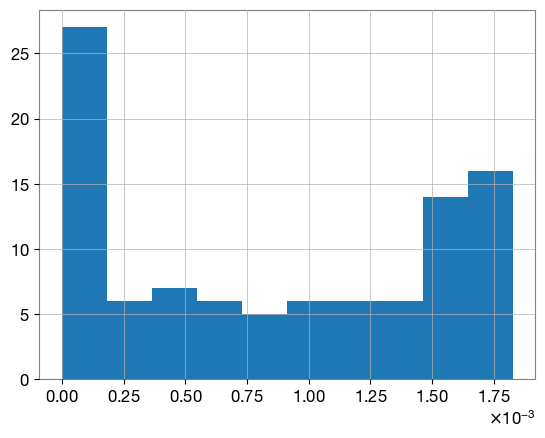

In [133]:
plt.hist(tau_integrand_list)

In [45]:
sample_lens_parameters(5)

{'zl': array([0.5, 0.5, 0.5, 0.5, 0.5]),
 'zs': array([1., 1., 1., 1., 1.]),
 'sigma': array([220.4584413 , 279.58491008, 262.31777363, 290.97389777,
        305.67147934]),
 'q': array([0.71519388, 0.74670181, 0.70882924, 0.66435015,
        0.84899359]),
 'theta_E': array([2.91087298e-06, 4.68163169e-06, 4.12121455e-06,
        5.07081601e-06, 5.59602475e-06]),
 'phi': array([6.26849202, 4.91906804, 1.36428438, 1.92286349,
        2.82159755]),
 'e1': array([ 0.16597724, -0.13280153, -0.15606392, -0.15370744,
         0.06550725]),
 'e2': array([-0.00487891, -0.05825067,  0.06839206, -0.13055611,
        -0.04877202]),
 'gamma1': array([-0.03170631,  0.01512897,  0.0282613 ,  0.02183705,
        -0.05179437]),
 'gamma2': array([ 0.01579342,  0.02452969, -0.05938726,  0.03576823,
         0.07366597]),
 'gamma': array([2.17907968, 1.97299403, 1.78087064, 1.70130207,
        2.11842971])}

In [ ]:
einstein_radius = lens_parameters[8]
iteration = lens_parameters[9]

# define return value if strong lensing condition not satisfied

# lensModel parameters are the same for the three functions used for image param calculation
# 1. x-y position of images in the source plane, 2. magnifications, 3. time-delays (relative)
lensModel = LensModel(
    lens_model_list=lens_parameters[10:].tolist(), z_lens=zl, z_source=zs
)

lens_eq_solver = LensEquationSolver(lensModel)

factor = 1.0
# ---------------------------------------------------#
#     x-y position of images in the source plane
# ---------------------------------------------------#
# Get the caustic curve cut by the lens
# First check if there is any nan in the caustic points
while True:
    kwargs_lens = [
        {
            "theta_E": factor,
            "e1": lens_parameters[1],
            "e2": lens_parameters[2],
            "gamma": lens_parameters[3],
            "center_x": 0.0,
            "center_y": 0.0,
        },
        {
            "gamma1": lens_parameters[4],
            "gamma2": lens_parameters[5],
            "ra_0": 0,
            "dec_0": 0,
        },
    ]
    caustic_double_points = caustics_epl_shear(
        kwargs_lens, return_which="double", maginf=-100
    )
    caustic = np.logical_not(np.isnan(caustic_double_points).any())

    # If there is a nan, caustic=False, draw a new gamma
    if caustic:
        break
    else:
        print("Found invalid caustic. Will resample parameters.")

caustic_double = Polygon(caustic_double_points.T)

In [ ]:
# lens_parameters[0] = min_images : minimum number of images
# lens_parameters[1] = e1 : ellipticity
# lens_parameters[2] = e2 : ellipticity
# lens_parameters[3] = gamma : power-law index
# lens_parameters[4] = gamma1 : shear
# lens_parameters[5] = gamma2 : shear
# lens_parameters[6] = zl : redshift of the lens
# lens_parameters[7] = zs : redshift of the source
# lens_parameters[8] = einstein_radius : Einstein radius
# lens_parameters[9] = iteration : iteration number
# lens_parameters[10:] = lens_model_list : numpy array of lens models

In [28]:
lens_parameters = np.array([2, 0.024069457093642648, -0.016002190961948142, 1.8945414936459974, 0.10117465203892329, 0.09600089396968613, 0.2503743800068136, 0.9418211055453296, 2.5055790287104725e-06, 0, 'EPL_NUMBA', 'SHEAR'], dtype=object)
lens_parameters = np.array([2, -0.04030088581646998, -0.01419438113690042, 2.0068239327017, 0.08482718989370612, -0.015393332086560785, 1.0952303138971118, 2.5534097159384417, 1.0125570159563301e-06, 1, 'EPL_NUMBA', 'SHEAR'], dtype=object)

In [30]:
for i in range(len(lens_parameters)):
    print(f"{i} : {lens_parameters[i]}")

0 : 2
1 : -0.04030088581646998
2 : -0.01419438113690042
3 : 2.0068239327017
4 : 0.08482718989370612
5 : -0.015393332086560785
6 : 1.0952303138971118
7 : 2.5534097159384417
8 : 1.0125570159563301e-06
9 : 1
10 : EPL_NUMBA
11 : SHEAR


In [ ]:
# @njit makes it slower
def tau_integrand(zl, zs):

    # velocity dispersion #
    size = 5000
    sigma = vd_sampler(size, zl)

    # axis ratio 
    q = axis_ratio_rayleigh(sigma)  # if SIS, q=array of 1.0

    # 

    # einstein radius 
    Dls = (Da_zs*(1+zs) - Da(zl)*(1+zl))/(1+zs)
    theta_E = (
        4.0 * np.pi * (sigma / 299792.458) ** 2 * Dls / Da_zs
    )  # Note: km/s for sigma; Dls, Ds are in Mpc

    # cross section 
    cross_section_SIS = theta_E ** 2  # np.pi is ommited
    
    result = phi_cut_SIE(q) * cross_section_SIS/4 * no * dVcdz(zl)
    # average
    return np.mean(result)

In [21]:
zs = 1.0
zl = 


einstein_radius = lens_parameters[8]
iteration = lens_parameters[9]

# define return value if strong lensing condition not satisfied

# lensModel parameters are the same for the three functions used for image param calculation
# 1. x-y position of images in the source plane, 2. magnifications, 3. time-delays (relative)
lensModel = LensModel(
    lens_model_list=lens_parameters[10:].tolist(), z_lens=zl, z_source=zs
)

lens_eq_solver = LensEquationSolver(lensModel)

factor = 1.0
# ---------------------------------------------------#
#     x-y position of images in the source plane
# ---------------------------------------------------#
# Get the caustic curve cut by the lens
# First check if there is any nan in the caustic points
while True:
    kwargs_lens = [
        {
            "theta_E": factor,
            "e1": lens_parameters[1],
            "e2": lens_parameters[2],
            "gamma": lens_parameters[3],
            "center_x": 0.0,
            "center_y": 0.0,
        },
        {
            "gamma1": lens_parameters[4],
            "gamma2": lens_parameters[5],
            "ra_0": 0,
            "dec_0": 0,
        },
    ]
    caustic_double_points = caustics_epl_shear(
        kwargs_lens, return_which="double", maginf=-100
    )
    caustic = np.logical_not(np.isnan(caustic_double_points).any())

    # If there is a nan, caustic=False, draw a new gamma
    if caustic:
        break
    else:
        print("Found invalid caustic. Will resample parameters.")

caustic_double = Polygon(caustic_double_points.T)

In [26]:
x_source_array, y_source_array = [], []
for i in range(100):
    x_source, y_source = pointpats.random.poisson(caustic_double, size=1)
    x_source_array.append(x_source)
    y_source_array.append(y_source)

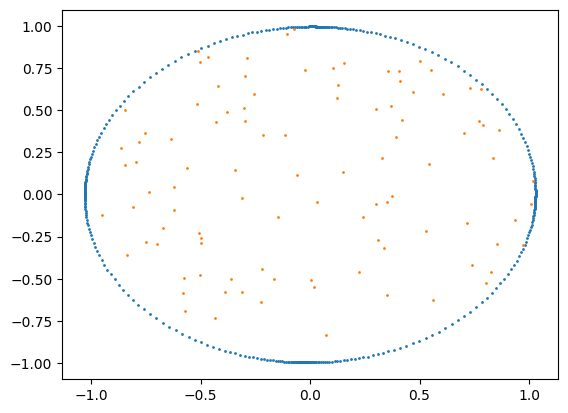

In [27]:
plt.scatter(*caustic_double.exterior.xy, s=1)
plt.scatter(x_source_array, y_source_array, s=1)
plt.show()

In [ ]:
# @njit makes it slower
def tau_integrand(zl, zs):

    # velocity dispersion #
    size = 5000
    lens_parameters = sample_lens_parameters(size=size, zl=zl, zs=zs)

    # einstein radius 
    Dls = (Da_zs*(1+zs) - Da(zl)*(1+zl))/(1+zs)
    theta_E = (
        4.0 * np.pi * (sigma / 299792.458) ** 2 * Dls / Da_zs
    )  # Note: km/s for sigma; Dls, Ds are in Mpc

    # cross section
    cross_section = cross_section_EPLShear(theta_E, lens_parameters)
    
    result =  cross_section_SIS/(4*np.pi) * no * dVcdz(zl)
    # average
    return np.mean(result)

In [32]:
from ler.lens_galaxy_population import LensGalaxyParameterDistribution

lens_class = LensGalaxyParameterDistribution()

z_to_luminosity_distance interpolator will be loaded from ./interpolator_pickle/z_to_luminosity_distance/z_to_luminosity_distance_0.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_0.pickle
merger_rate_density interpolator will be loaded from ./interpolator_pickle/merger_rate_density/merger_rate_density_0.pickle
z_to_Dc interpolator will be loaded from ./interpolator_pickle/z_to_Dc/z_to_Dc_0.pickle
Dc_to_z interpolator will be loaded from ./interpolator_pickle/Dc_to_z/Dc_to_z_0.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_0.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_1.pickle
velocity_dispersion_ewoud interpolator will be loaded from ./interpolator_pickle/velocity_dispersion_ewoud/velocity_d

/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/gwcosmo/prior/custom_math_priors.py:48: RuntimeWarning: overflow encountered in exp
  effe_prime[select_window] = _np.exp(_np.nan_to_num((delta_m/mprime[select_window])+(delta_m/(mprime[select_window]-delta_m))))
/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/gwcosmo/prior/custom_math_priors.py:162: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_prob(x)+_np.log(window)
/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/gwcosmo/prior/custom_math_priors.py:160: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_prob(x)+_np.log(window)-_np.log(self.norm)
/Users/phurailatpamhemantakumar/phd/mypackages/ler/ler/lens_galaxy_population/lens_galaxy_parameter_distribution.py:300: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields

In [41]:
from ler.utils import add_dictionaries_together, trim_dictionary
from lenstronomy.Util.param_util import phi_q2_ellipticity

def sample_lens_parameters(size, zl=0.5, zs=1.0, lens_parameters_input=None):
    """
        Function to sample galaxy lens parameters along with the source parameters.

        Parameters
        ----------
        size : `int`
            number of lens parameters to sample
        lens_parameters_input : `dict`
            dictionary of lens parameters to sample

        Returns
        -------
        lens_parameters : `dict`
            dictionary of lens parameters and source parameters (lens conditions applied): \n
            zl: lens redshifts \n
            zs: source redshifts, lensed condition applied\n
            sigma: velocity dispersions \n
            q: axis ratios \n
            theta_E: Einstein radii \n
            phi: axis rotation angle \n
            e1: ellipticity component 1 \n
            e2: ellipticity component 2 \n
            gamma1: shear component 1 \n
            gamma2: shear component 2 \n
            gamma: spectral index of the mass density distribution \n
            geocent_time: time of arrival of the unlensed signal\n
            phase: phase of the unlensed signal\n
            psi: polarization angle of the unlensed signal\n
            theta_jn: inclination angle of the unlensed signal\n
            luminosity_distance: luminosity distance of the source\n
            mass_1_source: mass 1 (larger) of the source\n
            mass_2_source: mass 2 (smaller) of the source\n
            ra: right ascension of the source\n
            dec: declination of the source\n

        Examples
        --------
        >>> from ler.lens_galaxy_population import LensGalaxyParameterDistribution
        >>> lens = LensGalaxyParameterDistribution()
        >>> lens.sample_all_routine(size=1000)
    """

    if lens_parameters_input is None:
        lens_parameters_input = dict()

    zs = np.array([zs] * size)
    zl = np.array([zl] * size)

    # Sample velocity dispersions
    try:
        sigma = lens_class.sample_velocity_dispersion(len(zs))
    except:
        sigma = lens_class.sample_velocity_dispersion(len(zs), zl)

    # Sample axis ratios
    try:
        q = lens_class.sample_axis_ratio(sigma)
    except:
        q = lens_class.sample_axis_ratio(len(sigma))

    # Compute the Einstein radii
    theta_E = lens_class.compute_einstein_radii(sigma, zl, zs)

    # Create a dictionary of the lens parameters
    lens_parameters = {
        "zl": zl,
        "zs": zs,
        "sigma": sigma,
        "q": q,
        "theta_E": theta_E,
    }

    # Rejection sample based on the lensing probability, that is, rejection sample wrt theta_E
    lens_parameters = lens_class.rejection_sample_sl(
        lens_parameters
    )  # proportional to pi theta_E^2

    # Add the lensing parameter dictionaries together
    lens_parameters = add_dictionaries_together(
        lens_parameters, lens_parameters_input
    )

    # check the size of the lens parameters
    if len(lens_parameters["zl"]) < size:
        # Run iteratively until we have the right number of lensing parmaeters
        # print("current sampled size", len(lens_parameters["zl"]))
        return sample_lens_parameters(
            size=size, lens_parameters_input=lens_parameters
        )
    else:
        # Trim dicitionary to right size
        lens_parameters = trim_dictionary(lens_parameters, size)

        # Sample the axis rotation angle
        lens_parameters["phi"] = lens_class.sample_axis_rotation_angle(size=size)

        # Transform the axis ratio and the angle, to ellipticities e1, e2, using lenstronomy
        lens_parameters["e1"], lens_parameters["e2"] = phi_q2_ellipticity(
            lens_parameters["phi"], lens_parameters["q"]
        )

        # Sample shears
        lens_parameters["gamma1"], lens_parameters["gamma2"] = lens_class.sample_shear(
            size=size)

        # Sample the spectral index of the mass density distribution
        lens_parameters["gamma"] = lens_class.sample_mass_density_spectral_index(
            size=size)

        return lens_parameters

In [42]:
sample_lens_parameters(5)

{'zl': array([0.5, 0.5, 0.5, 0.5, 0.5]),
 'zs': array([1., 1., 1., 1., 1.]),
 'sigma': array([ 82.88617496, 172.52875452, 181.14819861, 177.98217279,
        179.7709499 ]),
 'q': array([0.43653863, 0.56810848, 0.91035873, 0.6040788 ,
        0.64566059]),
 'theta_E': array([4.11466029e-07, 1.78275952e-06, 1.96534061e-06,
        1.89724229e-06, 1.93556970e-06]),
 'phi': array([5.38767281, 4.40078479, 0.90285292, 4.72439966,
        1.52511311]),
 'e1': array([-0.08568492, -0.22364542, -0.01092175, -0.24675033,
        -0.21441934]),
 'e2': array([-0.38276199,  0.16074821,  0.04563505, -0.00592842,
         0.01964543]),
 'gamma1': array([ 0.01230129,  0.01883225, -0.02152942,  0.01136105,
         0.02064367]),
 'gamma2': array([-0.00818756,  0.06147825, -0.09419915, -0.05256186,
         0.04500808]),
 'gamma': array([2.04048   , 2.08385245, 2.19121473, 2.11353067,
        2.15924686])}

In [46]:
from ler.rates import LeR

ler = LeR()

z_to_luminosity_distance interpolator will be loaded from ./interpolator_pickle/z_to_luminosity_distance/z_to_luminosity_distance_0.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_0.pickle
merger_rate_density interpolator will be loaded from ./interpolator_pickle/merger_rate_density/merger_rate_density_0.pickle
z_to_Dc interpolator will be loaded from ./interpolator_pickle/z_to_Dc/z_to_Dc_0.pickle
Dc_to_z interpolator will be loaded from ./interpolator_pickle/Dc_to_z/Dc_to_z_0.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_0.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_1.pickle
velocity_dispersion_ewoud interpolator will be loaded from ./interpolator_pickle/velocity_dispersion_ewoud/velocity_d

/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/gwcosmo/prior/custom_math_priors.py:48: RuntimeWarning: overflow encountered in exp
  effe_prime[select_window] = _np.exp(_np.nan_to_num((delta_m/mprime[select_window])+(delta_m/(mprime[select_window]-delta_m))))
/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/gwcosmo/prior/custom_math_priors.py:162: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_prob(x)+_np.log(window)
/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/gwcosmo/prior/custom_math_priors.py:160: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_prob(x)+_np.log(window)-_np.log(self.norm)
/Users/phurailatpamhemantakumar/phd/mypackages/ler/ler/lens_galaxy_population/lens_galaxy_parameter_distribution.py:300: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_0.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_0.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_0.pickle

 # LeR set up params:
npool = 4,
z_min = 0.0,
z_max = 10.0,
event_type = 'BBH',
size = 100000,
batch_size = 50000,
cosmology = LambdaCDM(H0=70.0 km / (Mpc s), Om0=0.3, Ode0=0.7, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=None),
snr_finder = <bound method GWSNR.snr of <gwsnr.gwsnr.GWSNR object at 0x346973340>>,
json_file_names = {'ler_params': 'ler_params.json', 'unlensed_param': 'unlensed_param.json', 'unlensed_param_detectable': 'unlensed_param_detectable.json', 'lensed_param': 'lensed_param.json', 'lensed_param_detectable': 'lensed_param_detectable.json'},
interpolator_directory = './interpolator_pickle',
ler_directory = './ler_data',

 # LeR also ta

classDiagram
direction BT
class node6
class node3
class node4
class node2
class node5
class node0
class node1

node3  -->  node6 
node6  -->  node2 
node4  -->  node2 
node5  -->  node2 
node6  -->  node0 
node2  -->  node1 